In [18]:
using ForneyLab
using BenchmarkTools

In [19]:
@btime begin
    n_samples = 20
    x_data = [t for t=1:n_samples] # State
    y_data = x_data + sqrt(200.0)*randn(n_samples); # Noisy observations of state

    g = FactorGraph()

    # Prior statistics
    m_x_0 = placeholder(:m_x_0)
    v_x_0 = placeholder(:v_x_0)

    # State prior
    @RV x_0 ~ GaussianMeanVariance(m_x_0, v_x_0)

    # Transition and observation model
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)

    x_t_min = x_0
    for t = 1:n_samples
        @RV n_t ~ GaussianMeanVariance(0.0, 200.0) # observation noise
        @RV x[t] = x_t_min + 1.0
        @RV y[t] = x[t] + n_t

        # Data placeholder
        placeholder(y[t], :y, index=t)

        # Reset state for next step
        x_t_min = x[t]
    end

    eval(Meta.parse(sumProductAlgorithm(x))) # Load algorithm

    # Prepare data dictionary and prior statistics
    data = Dict(:y     => y_data,
                :m_x_0 => 0.0,
                :v_x_0 => 1000.0)

    # Execute algorithm
    marginals = step!(data);
end;

  2.030 s (394524 allocations: 170.92 MiB)


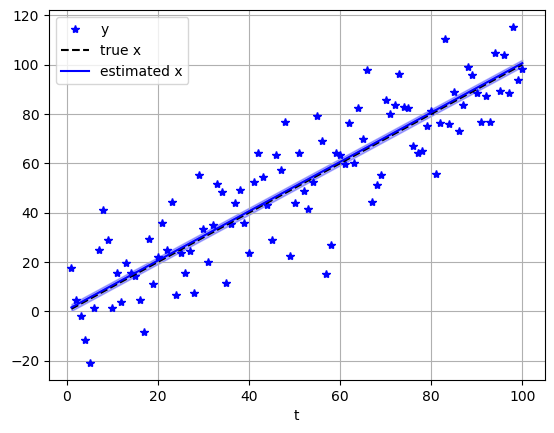

In [13]:
using PyPlot

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples]

plot(collect(1:n_samples), y_data, "b*", label="y")
plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(1:n_samples, m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");